# ECCO HEAT BUDGET - revised

### 13-tile native lat-lon-cap 90 grid
The lat-lon-cap (llc) is the decomposition of the spherical Earth into a Cartesian curvilinear coordinate system . It is a topologically non-trivial cubed-sphere rendering in the northern hemisphere and a dipolar grid in the southern hemisphere. Between 70°S and ~57°N, model grid cells are approximately oriented to lines of latitude and longitude. A special Arctic “cap” is situated north of ~57°N.

The Cartesian curvilinear coordinate system is divided into 13 tiles, each consisting of 90x90 grid cells in the horizontal and 50 vertical levels. Horizontal model grid resolution varies spatially from 22km to 110km, with the highest resolutions at high latitudes and lowest resolution in mid latitudes. Vertical grid spacing increases with depth from 10m to 456.5m. The bottom of the deepest model grid cell is 6145m below the surface.
https://ecco-v4-python-tutorial.readthedocs.io/fields.html

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [2]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [3]:
dt_values = (np.diff(ds.time_snp) / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'],
                  coords={'time': (['time'], ds.time.values[1:-1])})
ds.coords['dt'] = dt
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll#.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50, roll_coords=True)#(i=100, i_g=100)
ds 

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 50, 270, 360)","(1, 50, 90, 90)"
Count,31 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
#view current coord structure of i
coords.i.values
#locate 0, that's where -180 is
coords.i.values[50]
#create lon object to replace current i indexing
lon = np.arange(-180, 180)
#roll lon appropriately so new indexing values matches actual grid
lon_rolled = np.roll(lon, 50)
#insert new lon indices for both i & i_g
ds['i'] = lon_rolled
ds['i_g'] = lon_rolled

In [18]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 90 #-56.73891

j_g_upper = 90 #-56.2021
i_g_right = 118
i_g_left = 22

In [6]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [19]:
print('x', ds.ADVx_TH[10].isel(**lat_range, i_g=i_g_right).coords, 
      '\n y', ds.ADVy_TH[10].isel(**lon_range, j_g=j_g_upper).coords)

x Coordinates:
    i_g      int64 -112
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14 
 y Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
    j_g      int64 90
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14


In [20]:
print('x', ds.DFxE_TH[10].isel(**lat_range, i_g=i_g_right).coords, 
      '\n y', ds.DFyE_TH[10].isel(**lon_range, j_g=j_g_upper).coords)

x Coordinates:
    i_g      int64 -112
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14 
 y Coordinates:
  * i        (i) int64 153 154 155 156 157 158 ... -118 -117 -116 -115 -114 -113
    j_g      int64 90
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14


In [43]:
print('x', ds.ADVx_TH[10].isel(**lat_range, i_g=right_lon).coords, 
      '\n y', ds.ADVy_TH[10].isel(**lon_range, j_g=upper_lat).coords)

x Coordinates:
    i_g      int64 68
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14 
 y Coordinates:
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    j_g      int64 90
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14


In [44]:
print('x', ds.DFxE_TH[10].isel(**lat_range, i_g=right_lon).coords, 
      '\n y', ds.DFyE_TH[10].isel(**lon_range, j_g=upper_lat).coords)

x Coordinates:
    i_g      int64 68
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14 
 y Coordinates:
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    j_g      int64 90
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    time     datetime64[ns] 1992-11-14


In [21]:
#advective flux
adv_flux_y = ds.ADVy_TH[10].isel(**lon_range, j_g=j_g_upper).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_TH[10].isel(**lat_range, i_g=i_g_right).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
#units: (˚C m^3)/s

In [22]:
#diffusive flux
diff_flux_y = ds.DFyE_TH[10].isel(**lon_range, j_g=j_g_upper).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_TH[10].isel(**lat_range, i_g=i_g_right).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
#units: (˚C m^3)/s

In [7]:
#advective flux
adv_flux_y = ds.ADVy_TH[10].isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_TH[10].isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
#units: (˚C m^3)/s

In [8]:
#diffusive flux
diff_flux_y = ds.DFyE_TH[10].isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_TH[10].isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
#units: (˚C m^3)/s

In [23]:
#calculating total tendency term for heat
delta_theta = ds.THETA_snp.diff('time_snp')

#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data,
                                    'k':coords.k.data,
                                    'j':coords.j.data,
                                    'i':coords.i.data})
delta_theta

,Array,Chunk
Bytes,5.18 GiB,1.54 MiB
Shape,"(286, 50, 270, 360)","(1, 50, 90, 90)"
Count,34 Graph Layers,3432 Chunks
Type,float32,numpy.ndarray


In [24]:
theta_tend = (delta_theta / coords.dt[1:287])
volume = (coords.drF * coords.rA * coords.hFacC)
totttend = theta_tend * volume

In [25]:
tottend_wg = totttend[10].isel(**lat_range, **lon_range).sum(('i','j','k')).load()

In [26]:
#vertical flux
t_flux_z = (ds.TFLUX * coords.rA * coords.hFacC.isel(k=0)).isel(time=0, **lat_range, **lon_range).sum(dim=['i','j']).load()
#units: W = (kg*m^2)/s^3

In [27]:
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)

#ECCO has nonlinear surface so don't wry about 'lin_fs_correction' term
#units: (˚C m^3)/s

In [28]:
rhs = -adv_flux - diff_flux + surface_term
lhs = tottend_wg

In [29]:
(rhs -lhs)/1e6

<xarray.DataArray ()>
array(-90.67755055)
Coordinates:
    i_g      int64 -112
    j_g      int64 90
    k        int64 0
    time     datetime64[ns] 1992-12-15

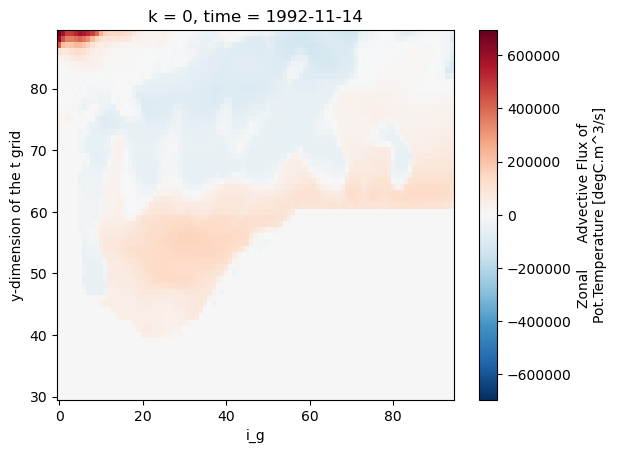

In [37]:
ds.ADVx_TH[10].isel(**lat_range, i_g=slice(left_lon,i_g_right))[0].drop('i_g').plot()

## Advection & Diffusion

In [8]:
#advective flux
adv_flux_y = ds.ADVy_TH[10].isel(**lon_range, j_g=j_g_upper).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_TH[10].isel(**lat_range, i_g=i_g_right).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
#units: (˚C m^3)/s

In [9]:
#diffusive flux
diff_flux_y = ds.DFyE_TH[10].isel(**lon_range, j_g=j_g_upper).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_TH[10].isel(**lat_range, i_g=i_g_right).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
#units: (˚C m^3)/s

## Surface flux

### 2 ways of defining surface fluxes

#### 1st way

In [13]:
#vertical flux
t_flux_z = (ds.TFLUX * coords.rA * coords.hFacC.isel(k=0)).isel(time=0, **lat_range, **lon_range).sum(dim=['i','j']).load()
#units: W = (kg*m^2)/s^3

heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)

#ECCO has nonlinear surface so don't wry about 'lin_fs_correction' term
#units: (˚C m^3)/s

#### 2nd way

In [14]:
# constants
heat_capacity_cp = 3.994e3 #J/kg˚C
runit2mass = 1.035e3 #kg/m3

# treat the shortwave flux separately from the rest of the surface flux

#surf flux
surf_flux_th = (ds.TFLUX - ds.oceQsw) * coords.rA * coords.hFacC.isel(k=0) / (heat_capacity_cp * runit2mass) #˚C m^3/s
_, surf_flux_th_aligned = xr.align(coords.hFacC, surf_flux_th.expand_dims('k'), join='outer')
surf_flux_th_aligned = surf_flux_th_aligned.fillna(0.)

#sw flux
surf_flux_th_sw = ds.oceQsw * coords.rA * coords.hFacC.isel(k=0) / (heat_capacity_cp * runit2mass) #˚C m^3/s

In [49]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = fact * coords.Zl.sel(k_l=slice(0, 18))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(coords.Zl, surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [50]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 
                             'Y': {'center': 'j', 'left': 'j_g'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'k', 'left': 'k_l', 'outer': 'k_p1', 'right': 'k_u'}},
                             periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center

In [51]:
#convergence of swdown
sw = -grid.diff(swdown, 'Z', boundary='fill')
sw

,Array,Chunk
Bytes,5.21 GiB,1.54 MiB
Shape,"(288, 270, 360, 50)","(1, 90, 90, 50)"
Count,138 Graph Layers,3456 Chunks
Type,float32,numpy.ndarray


In [55]:
surf_term = (sw + surf_flux_th_aligned).isel(time=10, **lat_range, **lon_range).sum(('i','j','k')).load()

## Total tendency

### 2 ways of defining total tendency

#### 1st way

In [9]:
#calculating total tendency term for heat
delta_theta = ds.THETA_snp.diff('time_snp')

#forcing theta_scaled to have same timestamp as ds.dt by creating new data array called "theta_scaled"
delta_theta = xr.DataArray(delta_theta.data, dims=['time','k','j','i'], 
                            coords={'time': coords.dt[1:287].time.data,
                                    'k':coords.k.data,
                                    'j':coords.j.data,
                                    'i':coords.i.data})
delta_theta

,Array,Chunk
Bytes,5.18 GiB,1.54 MiB
Shape,"(286, 50, 270, 360)","(1, 50, 90, 90)"
Count,34 Graph Layers,3432 Chunks
Type,float32,numpy.ndarray


In [10]:
theta_tend = (delta_theta / coords.dt[1:287])
volume = (coords.drF * coords.rA * coords.hFacC)
totttend = theta_tend * volume

In [11]:
tottend_wg = totttend[10].isel(**lat_range, **lon_range).sum(('i','j','k')).load()

#### 2nd way

In [26]:
surface_term

<xarray.DataArray ()>
array(1.28566368e+08)
Coordinates:
    time     datetime64[ns] 1992-01-15
    k        int64 0

In [15]:
rhs = -adv_flux - diff_flux + surface_term
lhs = tottend_wg

In [16]:
(rhs -lhs)/1e6

<xarray.DataArray ()>
array(35.93963588)
Coordinates:
    i_g      int64 -63
    j_g      int64 75
    k        int64 0
    time     datetime64[ns] 1992-12-15

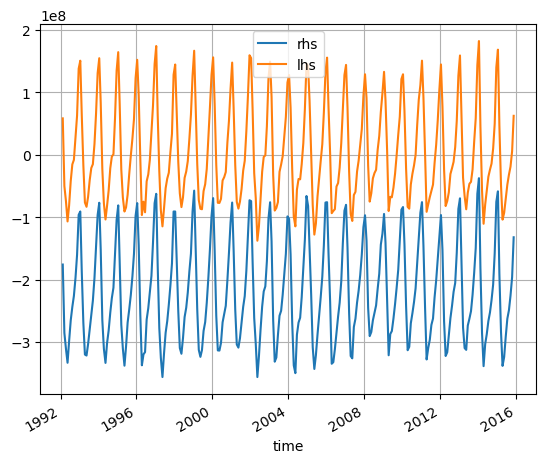

In [39]:
rhs = -adv_flux[1:-1] - diff_flux[1:-1] + surf_term[1:-1]
lhs = tottend_wg
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend()
plt.grid();

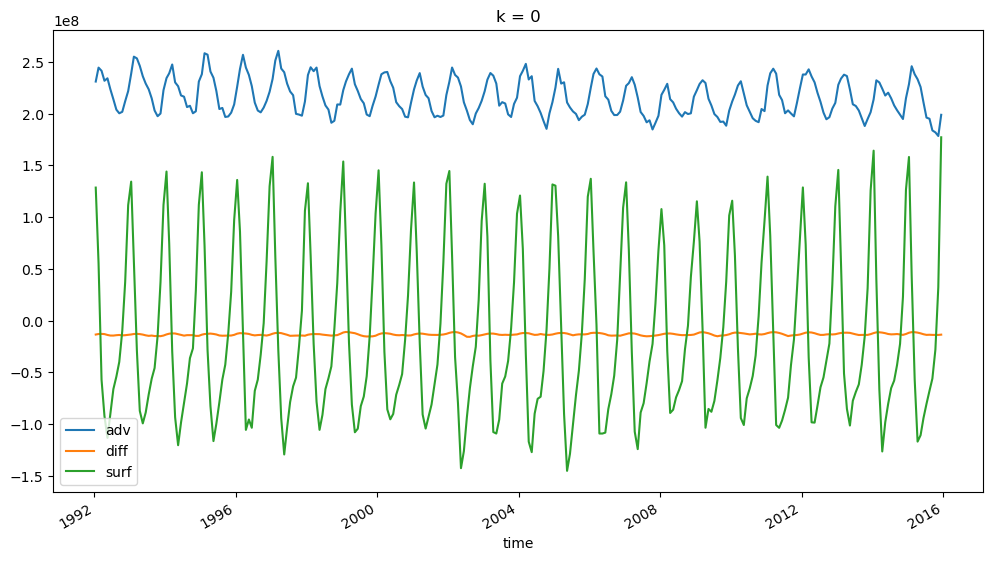

In [40]:
plt.figure(figsize=(12,6))
adv_flux.plot(label='adv')
diff_flux.plot(label='diff')
surface_term.plot(label='surf')
plt.legend()

## Heat budget for Lower WG (-2,046m to bottom)

In [52]:
sst_mean_lower = ds.THETA.isel(k=36).mean(dim='time').load()

In [53]:
surface_mask_lower = (coords.hFacC.isel(k=36)>0).load()

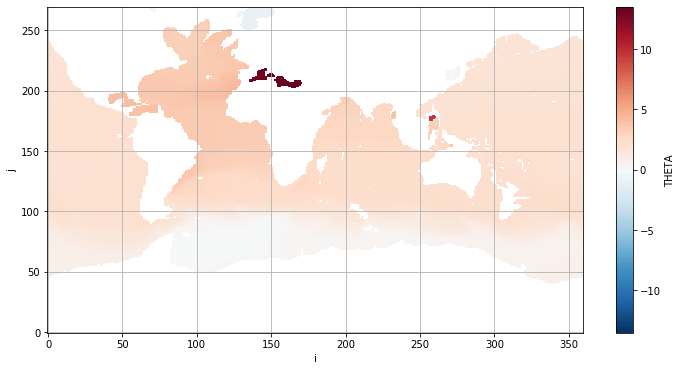

In [54]:
sst_mean_lower.where(surface_mask_lower).plot(figsize=(12,6))
plt.grid();

In [55]:
sst_mean_wg_lower = sst_mean_lower.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg_lower = surface_mask_lower.sel(i=slice(75, 167), j=slice(35, 75))

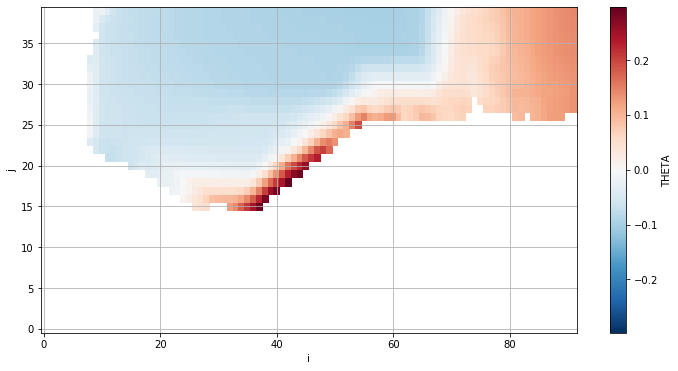

In [56]:
sst_mean_wg_lower.where(surface_mask_wg_lower).plot(figsize=(12,6))
plt.grid();

In [57]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

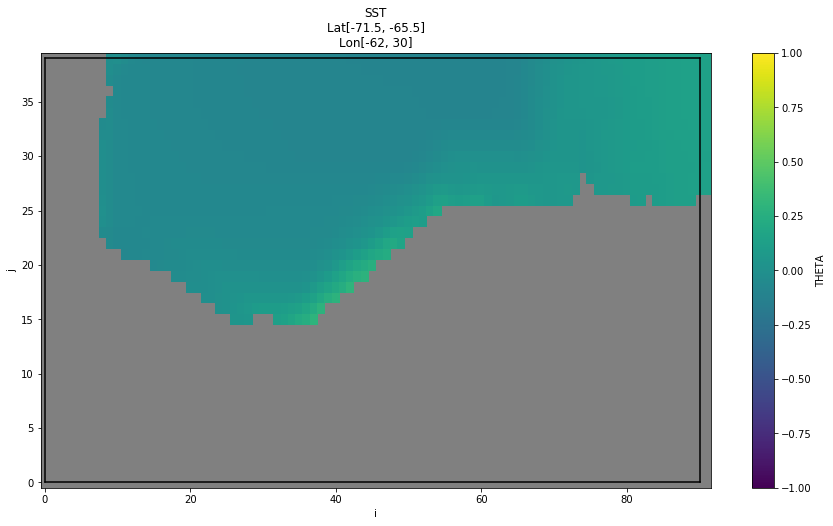

In [58]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sst_mean_wg_lower.where(surface_mask_wg_lower).plot(ax=ax,  vmin=-1, vmax=1)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [59]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167


lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [60]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [61]:
#advective flux
adv_flux_y_lower = ds.ADVy_TH.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
adv_flux_x_lower = ds.ADVx_TH.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
adv_flux_z_lower = ds.ADVr_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j']).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([-5.22148875e+05, -1.37863925e+06, -7.73351500e+05, -4.13085500e+05,
       -2.30887550e+06, -2.98221550e+06, -1.89213350e+06, -1.67236825e+06,
       -8.95417812e+04, -4.11769812e+05,  6.46511500e+05, -9.79401562e+05,
       -2.11089550e+06, -8.37470875e+05, -9.12925625e+05, -1.19821075e+06,
       -8.61151188e+05, -1.09752712e+06, -1.69873719e+05, -9.87580250e+05,
       -1.40006312e+06,  2.56836156e+05, -9.00550188e+05, -1.29334800e+06,
       -1.14253762e+06, -1.48316800e+06, -4.94404125e+05, -2.05509350e+06,
       -1.79438462e+06, -3.44151900e+06, -3.59223450e+06, -1.77197391e+05,
       -1.34935938e+06, -1.12965875e+06, -1.43327425e+06, -6.01705000e+05,
       -3.54835844e+05, -3.49309750e+05, -6.43073625e+05, -3.69568531e+05,
       -1.11469075e+06, -5.40205125e+05, -3.20880725e+06, -8.92341875e+05,
       -8.76573188e+05,  1.94922812e+05,  5.83546406e+04,  7.76434062e+05,
       -5.52600562e+05, -3.29631969e+05,  2.16091312e+05, -8.64053750

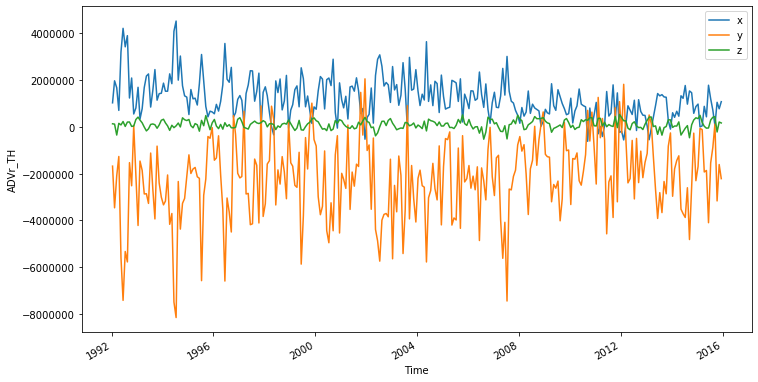

In [62]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [63]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_TH.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                              dim=['i','k']).load()
diff_flux_x_lower = ds.DFxE_TH.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                              dim=['j','k']).load()
diff_flux_z_lower = ((ds.DFrE_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])
                    + ds.DFrI_TH.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 288)>
array([243964.03  , 217606.33  , 202374.28  , 192274.08  , 232227.53  ,
       291486.2   , 372205.47  , 416333.34  , 400257.38  , 367774.38  ,
       321882.88  , 285788.2   , 257877.53  , 232121.44  , 214171.75  ,
       199123.6   , 201046.    , 169967.02  , 190148.66  , 222906.06  ,
       237019.11  , 235988.8   , 213936.47  , 189200.22  , 168097.5   ,
       154403.22  , 148352.88  , 137310.03  , 144500.33  , 186441.84  ,
       200594.31  , 223882.69  , 215316.84  , 194199.4   , 169666.53  ,
       140583.27  , 117980.516 , 101042.73  ,  94485.47  ,  85586.88  ,
       105861.83  ,  95280.34  ,  97013.9   , 114060.31  , 103631.914 ,
        88418.05  ,  87452.82  ,  77479.984 ,  57535.027 ,  54729.64  ,
        43682.273 ,  36254.977 ,  64390.293 , 105407.97  , 166882.64  ,
       170712.62  , 154634.72  , 135994.72  , 136792.2   , 117095.3   ,
        80579.45  ,  66169.05  ,  55130.57  ,  46368.023 ,  80229.37  ,
       103084.47  , 139601.1   , 

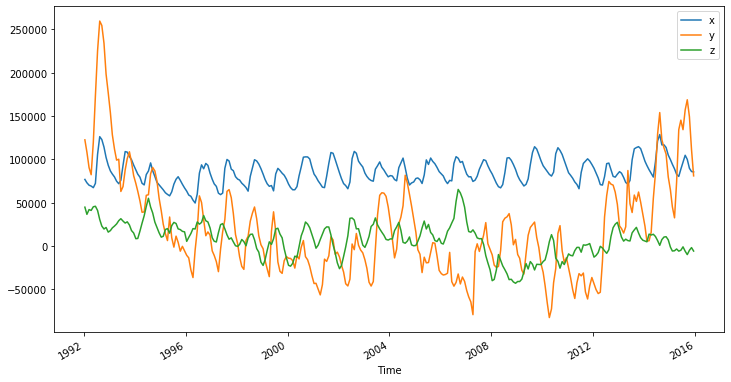

In [64]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [65]:
tottend_weddell_lower = (theta_tend * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['i', 'j','k'])
tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 286)>
array([ 1.20629868e+06,  6.16240007e+05,  2.66077268e+05,  2.12191159e+06,
        2.73599464e+06,  1.56519285e+06,  1.30129909e+06, -2.65450485e+05,
        8.92601889e+04, -9.23129337e+05,  7.38877507e+05,  1.89828247e+06,
        6.50614461e+05,  7.44017901e+05,  1.04435168e+06,  7.05369327e+05,
        9.72825690e+05,  2.49896347e+04,  8.09938780e+05,  1.20830840e+06,
       -4.47560244e+05,  7.31877893e+05,  1.14941251e+06,  1.01970431e+06,
        1.37403064e+06,  3.91314079e+05,  1.96304862e+06,  1.69514876e+06,
        3.30034263e+06,  3.43690557e+06, -1.42118918e+03,  1.17930598e+06,
        9.80724174e+05,  1.30887291e+06,  5.06386886e+05,  2.82119582e+05,
        2.93531286e+05,  5.93852902e+05,  3.29246301e+05,  1.05409289e+06,
        4.90189039e+05,  3.15705823e+06,  8.23545850e+05,  8.18206439e+05,
       -2.38076332e+05, -1.00542637e+05, -8.08649689e+05,  5.40330055e+05,
        3.20167236e+05, -2.14508249e+05,  8.73062365e+05,  1.79020008

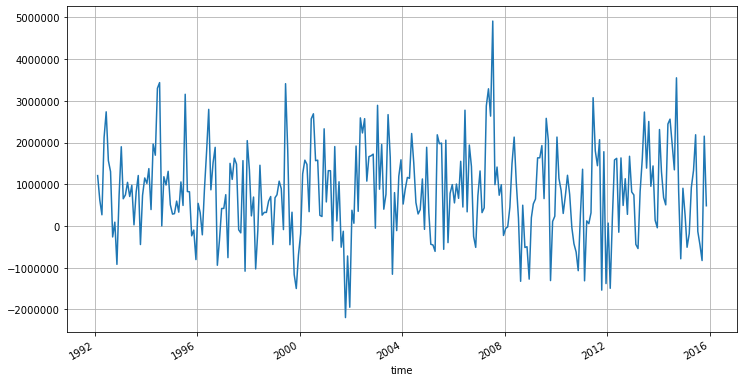

In [66]:
tottend_weddell_lower.plot(figsize=(12,6))
plt.grid()

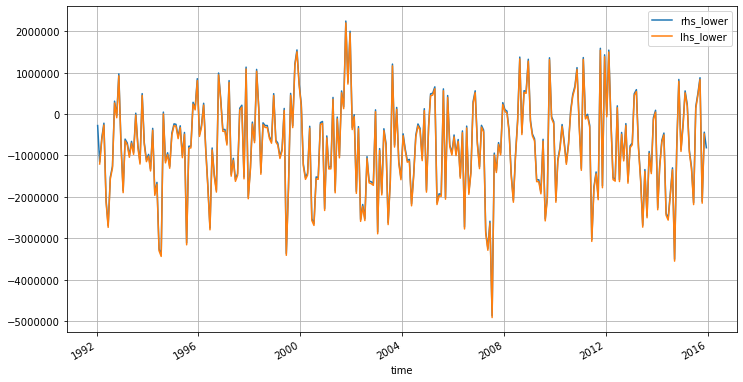

In [67]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower + diff_flux_lower
lhs_lower = - tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();
#plt.savefig('SOSE-heat-inter-rhs-lhs-timeseries', format='pdf')